<a href="https://colab.research.google.com/github/min02yam/wether/blob/main/%EC%98%88%EB%B3%B4_2012_2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

예보데이터(2012~2016) <br>


# 0.라이브러리 및 데이터 로드

In [4]:
install.packages(c("DataExplorer","imputeTS", "lubridate"))
suppressPackageStartupMessages({
library(DataExplorer) #EDA
library(imputeTS) # imputation
library(lubridate) # 날짜
})

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
suppressPackageStartupMessages({
  require(tidyverse)
  require(magrittr)
  require(data.table)
})

In [6]:
system("gdown --id 1EkwbK7uSNOCuo5H3frhxsg2ZuAlTu7C0")  #2012
system("gdown --id 1L2NIn_hFZww3uGpysoWapSxF_-CIiBbF")  #2013
system("gdown --id 1pZ__BBjPH8PygXqU8DAInDHoWPH3SM1J")  #2014
system("gdown --id 1Yy7Zv5_cARL0f4qJFN3R2bxOQOQjfif8")  #2015
system("gdown --id 1exNYMxNSx6kPyEbEk2rKkaRVNSjGnO4Y")  #2016

In [7]:
f2012 =  fread("f2012.csv")
f2013 =  fread("f2013.csv")
f2014 =  fread("f2014.csv")
f2015 =  fread("f2015.csv")
f2016 =  fread("f2016.csv")

# 1.예보 테이블 병합

## 1-1.년도 병합

In [8]:
예보 = bind_rows(f2012, f2013, f2014, f2015, f2016)

In [9]:
#예보 %>%  summary # 확인

## 1-2. hospital 테이블 형식으로 변환

In [10]:
DT= rbind(예보, 예보)
DT %<>% 
  arrange(date, area)  %>% 
  mutate(sex = rep(1:2, times=nrow(DT)/2 ))

In [11]:
#step1. 새로운 date 테이블 만들기 만들기 
new_date= seq(as.Date('20120101', '%Y%m%d'), as.Date('20161231', '%Y%m%d'), 1)
new_date =rep(new_date , times= 17)
new_date= as.data.table(new_date)

new_date %<>%  rename( date = new_date )%>% 
  arrange(date) 

In [12]:
#step2. area변수 추가
area_list= c("강원", "경기", "경남", "경북",   "광주", "대구",
"대전","부산","서울","세종","울산","인천","전남", "전북","제주" , "충남","충북")
new_date$area =  rep(area_list, times=nrow(new_date)/17) 

In [13]:
#step3. sex변수 추가 
new_date_dt = rbind(new_date, new_date) #공간만들기
new_date_dt %<>% arrange(date,area) # 순서지정
new_date_dt$sex = rep(1:2,   times=nrow(new_date_dt)/2)

In [14]:
#step4. merge전 타입 변경
new_date_dt[, date := as.character(date)]
DT[, date  := as.character(date)]

In [15]:
new_date_dt %>% left_join(DT, by=c("date", "area", "sex")) -> 예보_최종

In [16]:
new_date %>% nrow() *2

[1] 62118

# 2.결측치 대체
- 새로운 날짜도 생겼음! 
- 그룹별(area)로 칼만 알고리즘 적용 

In [18]:
예보_최종 %>% summary

     date               area                sex      f평균3시간기온   
 Length:62118       Length:62118       Min.   :1.0   Min.   :-16.420  
 Class :character   Class :character   1st Qu.:1.0   1st Qu.:  3.333  
 Mode  :character   Mode  :character   Median :1.5   Median : 12.700  
                                       Mean   :1.5   Mean   : 11.648  
                                       3rd Qu.:2.0   3rd Qu.: 20.000  
                                       Max.   :2.0   Max.   : 30.800  
                                                     NA's   :3996     
 f평균강수형태     f평균습도      f평균하늘상태  
 Min.   :0.000   Min.   : 10.00   Min.   :1.000  
 1st Qu.:0.000   1st Qu.: 65.69   1st Qu.:2.000  
 Median :0.000   Median : 77.00   Median :3.000  
 Mean   :0.125   Mean   : 74.49   Mean   :2.574  
 3rd Qu.:0.000   3rd Qu.: 85.00   3rd Qu.:3.000  
 Max.   :3.000   Max.   :100.00   Max.   :4.000  
 NA's   :4016    NA's   :4764     NA's   :9938   

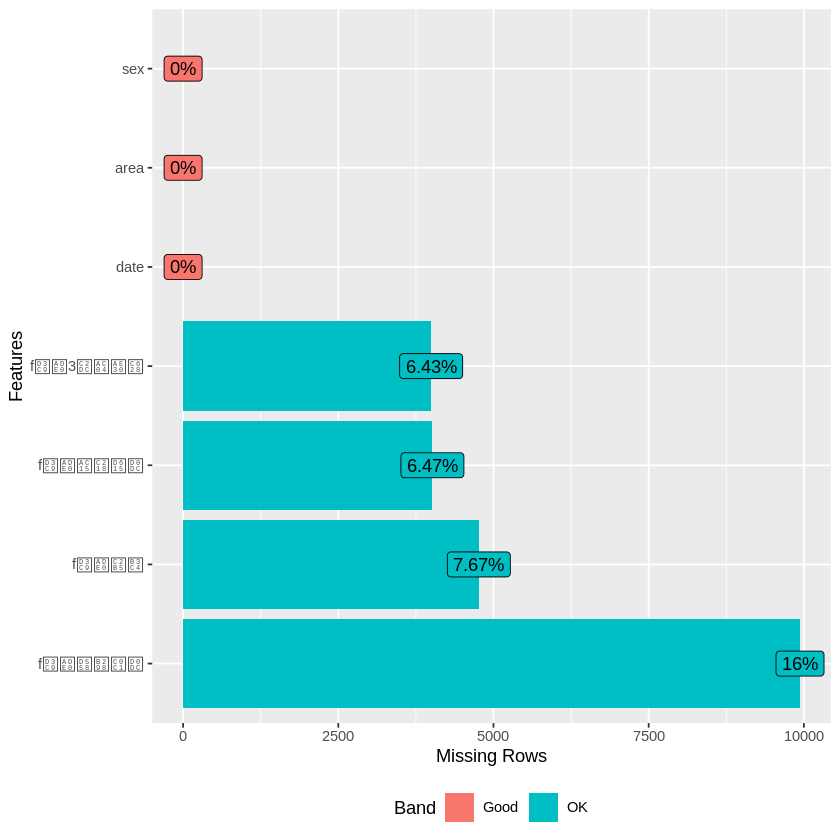

In [19]:
plot_missing(예보_최종)

In [50]:
예보_최종 %>% str

Classes ‘data.table’ and 'data.frame':	62118 obs. of  7 variables:
 $ date          : chr  "2012-01-01" "2012-01-01" "2012-01-01" "2012-01-01" ...
 $ area          : chr  "강원" "강원" "경기" "경기" ...
 $ sex           : int  1 2 1 2 1 2 1 2 1 2 ...
 $ f평균3시간기온: num  -5.49 -5.49 -5.94 -5.94 -1.22 ...
 $ f평균강수형태 : int  0 0 0 0 0 0 0 0 0 0 ...
 $ f평균습도     : num  63.7 63.7 77.2 77.2 63.2 ...
 $ f평균하늘상태 : int  2 2 2 2 3 3 3 3 3 3 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [52]:
# 지역별로 칼만 필터 알고리즘 적용해서 리스트로 반환
예보_최종 %>% group_split(area)  %>%
  lapply(function(x){na_kalman(x, model = "StructTS", smooth = TRUE)}) -> imp_list
#data.table로 변경
rbindlist(imp_list) -> imp_dt

Warning message:
“imputeTS: No imputation performed for column 4 because of this Error in na_kalman(data[, i], model, smooth, nit, maxgap, ...): Input data needs at least 3 non-NA data point for applying na_kalman
”
Warning message:
“imputeTS: No imputation performed for column 5 because of this Error in na_kalman(data[, i], model, smooth, nit, maxgap, ...): Input data needs at least 3 non-NA data point for applying na_kalman
”
Warning message:
“imputeTS: No imputation performed for column 6 because of this Error in na_kalman(data[, i], model, smooth, nit, maxgap, ...): Input data needs at least 3 non-NA data point for applying na_kalman
”
Warning message:
“imputeTS: No imputation performed for column 7 because of this Error in na_kalman(data[, i], model, smooth, nit, maxgap, ...): Input data needs at least 3 non-NA data point for applying na_kalman
”


In [55]:
imp_dt %>% summary 

     date               area                sex      f평균3시간기온  
 Length:62118       Length:62118       Min.   :1.0   Min.   :-16.42  
 Class :character   Class :character   1st Qu.:1.0   1st Qu.:  3.40  
 Mode  :character   Mode  :character   Median :1.5   Median : 12.80  
                                       Mean   :1.5   Mean   : 11.68  
                                       3rd Qu.:2.0   3rd Qu.: 20.00  
                                       Max.   :2.0   Max.   : 30.80  
                                                     NA's   :3654    
 f평균강수형태     f평균습도      f평균하늘상태  
 Min.   :0.000   Min.   : 10.00   Min.   :1.000  
 1st Qu.:0.000   1st Qu.: 65.79   1st Qu.:2.000  
 Median :0.000   Median : 77.00   Median :3.000  
 Mean   :0.124   Mean   : 74.48   Mean   :2.544  
 3rd Qu.:0.000   3rd Qu.: 85.00   3rd Qu.:3.000  
 Max.   :3.000   Max.   :100.00   Max.   :4.000  
 NA's   :3654    NA's   :3654     NA's   :3654   

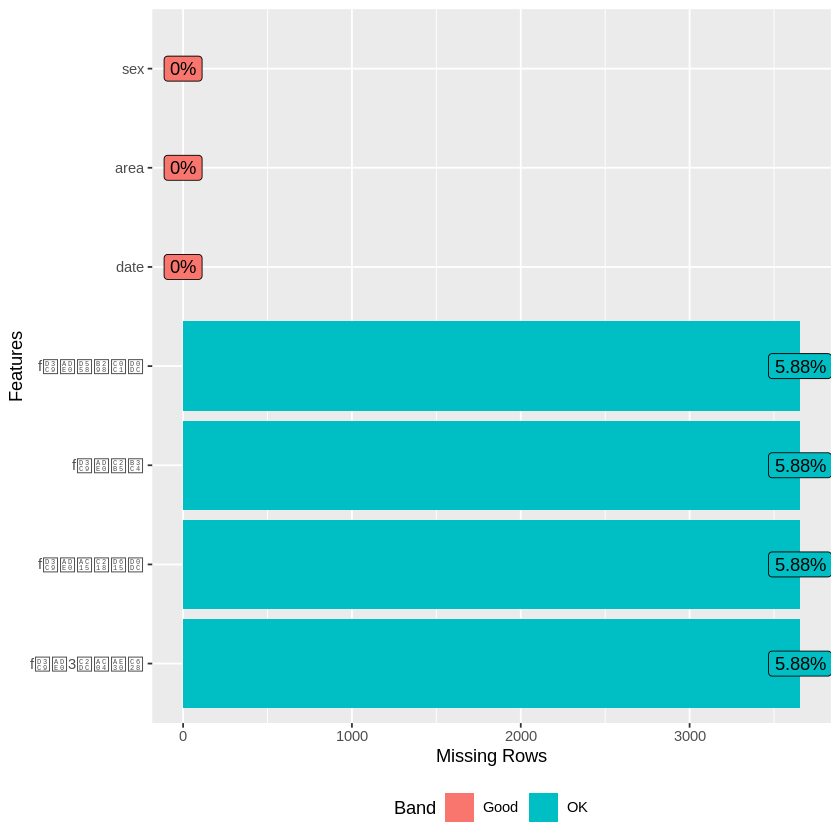

In [69]:
# 확인
plot_missing(imp_dt) 

In [ ]:
행만 따로 뽑음 

# 3.최종 테이블 병합

In [ ]:
#write.csv(imp_dt, "예보_최종.csv", row.names=FALSE)

In [10]:
#백업
#system("gdown --id 10KORE_pe157H4jAB8G4uTr_jA6D7x85-")
#dt = fread("예보_최종.csv")

In [189]:
#step1. 병합할 데이터 로드
system("gdown --id 1bZoMqMjFMjTxceAzRqINBnaMqsAT_eQH")
final = fread("ASOS_최종합_최종_최종.csv")
final %>% str

Classes ‘data.table’ and 'data.frame':	62118 obs. of  43 variables:
 $ yyyymmdd      : IDate, format: "2012-01-01" "2012-01-01" ...
 $ area          : chr  "강원" "강원" "경기" "경기" ...
 $ sex           : int  1 2 1 2 1 2 1 2 1 2 ...
 $ frequency     : int  3 3 4 5 2 1 6 1 0 2 ...
 $ avg_ta        : num  -2.58 -2.58 -3.11 -3.11 1.47 ...
 $ max_ta        : num  1.55 1.55 1.06 1.06 6.83 ...
 $ min_ta        : num  -6.61 -6.61 -7.4 -7.4 -2.83 ...
 $ avg_pa        : num  995 995 1017 1017 1015 ...
 $ max_pa        : num  997 997 1019 1019 1017 ...
 $ min_pa        : num  992 992 1015 1015 1012 ...
 $ avg_ps        : num  1023 1023 1025 1025 1023 ...
 $ max_ps        : num  1025 1025 1027 1027 1025 ...
 $ min_ps        : num  1019 1019 1022 1022 1020 ...
 $ avg_rhm       : num  62.5 62.5 71.8 71.8 59.6 ...
 $ min_rhm       : num  40.8 40.8 47.1 47.1 42.2 ...
 $ sum_ss_hr     : num  3.71 3.71 2.39 2.39 2.12 ...
 $ ssrate        : num  38.6 38.6 24.8 24.8 21.6 ...
 $ avg_pv        : num  3.07 3.07 

In [ ]:
list = list.files(pattern = "3시간기온") 
#데이터 로드 & 전처리
final <-NULL 
for (i in 1:length(list)){
  file = assign(list[i], read.csv(list [i],col.names = c("day", "hour", "forecast", "value")) )
  file$year = substr(file[which(is.na(file$hour))[1],'day'],10,13)
  file$month = paste0('0',as.integer(substr(file[which(is.na(file$hour))[1],'day'],14,15))-1)
  for (j in which(is.na(file$hour))){
    
    file[j:nrow(file),(ncol(file)-1)] = substr(file$day[j],10,13)
    file[j:nrow(file),ncol(file)] = substr(file$day[j],14,15)
  }
  file %<>% filter(! is.na(hour))  #na행 추가되어있음
  file$date = paste0(file$year,"-",file$month, "-",file$day) %>%
    parse_date_time(orders="ymd")
  final = rbind(final,file)
  cat("\n",i) 
}

final %>% str

In [ ]:
#step1.먼저 인덱스 번호 확인
#step2. 반복 시작되기 전 행까지 다시 불러옴
final <-NULL 
for (i in 1:length(list)){
  file = assign(list[i], read.csv(list [i],col.names = c("day", "hour", "forecast", "value")) )
  which = which(str_detect(file$day, 'format')) 
  file = assign(list[i], read.csv(list [i],
                col.names = c("day", "hour", "forecast", "value"),
                nrows = which - 1)
                )
  file$year = substr(file[which(is.na(file$hour))[1],'day'],10,13)
  file$month = paste0('0',as.integer(substr(file[which(is.na(file$hour))[1],'day'],14,15))-1)
  for (j in which(is.na(file$hour))){
    
    file[j:nrow(file),(ncol(file)-1)] = substr(file$day[j],10,13)
    file[j:nrow(file),ncol(file)] = substr(file$day[j],14,15)
  }
  file %<>% filter(! is.na(hour))  #na행 추가되어있음
  file$date = paste0(file$year,"-",file$month, "-",file$day) %>%
    parse_date_time(orders="ymd")
  final = rbind(final,file)
  cat("\n",i) 
}

In [ ]:
#step2. 변수명 바꾸기
    %>% rename(yyyymmdd = )

In [94]:
new =  final %>% right_join(DT, by=c("yyyymmdd", "area","sex"))

ERROR: ignored

In [ ]:
new =  hp_new  %>% right_join(성별준비, by=c("yyyymmdd", "area","sex"))

In [11]:
new = plyr::join_all(list(final ,DT),by= c("yyyymmdd", "area","sex"), type="left" )